# Search Audio Files based on Emotion 

In [1]:
import pandas as pd
import os
import librosa
import wav2clip
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
import json
from sentence_transformers import SentenceTransformer, util
import ipywidgets as widgets
from IPython.display import display, Audio, clear_output
import functools

In [2]:
emotion_data = pd.read_csv("data/Audio_and_Text_Embeddings/Emotify_Dataset/data.csv")

In [3]:
emotion_data.columns

Index(['track id', ' genre', ' amazement', ' solemnity', ' tenderness',
       ' nostalgia', ' calmness', ' power', ' joyful_activation', ' tension',
       ' sadness', ' mood', ' liked', ' disliked', ' age', ' gender',
       ' mother tongue'],
      dtype='object')

In [4]:
emotion_data.columns = emotion_data.columns.str.strip()

In [5]:
emotion_data

,track id,genre,amazement,solemnity,tenderness,nostalgia,calmness,power,joyful_activation,tension,sadness,mood,liked,disliked,age,gender,mother tongue
0,1,classical,0,1,0,0,0,0,1,1,0,3,1,0,21,1,English
1,1,classical,0,0,0,1,0,0,0,0,0,3,0,1,41,1,Dutch
2,1,classical,0,0,0,1,0,0,0,0,1,3,0,0,24,1,English
3,1,classical,0,0,0,0,1,0,0,0,0,3,0,0,32,0,Spanish
4,1,classical,0,0,0,1,1,0,0,0,0,4,0,1,21,0,English
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8402,400,pop,1,1,0,0,0,0,1,0,0,3,0,0,26,1,Russian
8403,400,pop,0,0,0,1,0,0,1,0,1,3,0,1,29,0,Russian
8404,400,pop,0,0,0,0,0,0,0,1,0,4,0,1,34,1,Polish
8405,400,pop,1,0,0,0,0,0,1,1,0,5,0,0,39,1,French


In [6]:
emotion_data['genre'].value_counts().to_dict

<bound method Series.to_dict of genre
classical     2688
rock          2038
pop           1855
electronic    1826
Name: count, dtype: int64>

In [ ]:
base_dir = "data/Emotify_Dataset"
genre_offsets = {"classical": 0, "rock": 100, "electronic": 200, "pop": 300}

for genre, offset in genre_offsets.items():
    genre_path = os.path.join(base_dir, genre)

    if not os.path.exists(genre_path):
        print(f"⚠️ Genre folder not found: {genre_path}")
        continue

    for filename in os.listdir(genre_path):
        if filename.endswith(".mp3"):
            try:
                old_track_id = int(os.path.splitext(filename)[0]) 
                new_track_id = old_track_id + offset 

                old_file_path = os.path.join(genre_path, filename)
                new_file_path = os.path.join(genre_path, f"{new_track_id}.mp3")

                os.rename(old_file_path, new_file_path)
                print(f"✅ Renamed {filename} → {new_track_id}.mp3")

            except ValueError:
                print(f"⚠️ Skipping invalid filename: {filename}")

print("🎯 Renaming complete!")

✅ Renamed 1.mp3 → 1.mp3
✅ Renamed 10.mp3 → 10.mp3
✅ Renamed 100.mp3 → 100.mp3
✅ Renamed 11.mp3 → 11.mp3
✅ Renamed 12.mp3 → 12.mp3
✅ Renamed 13.mp3 → 13.mp3
✅ Renamed 14.mp3 → 14.mp3
✅ Renamed 15.mp3 → 15.mp3
✅ Renamed 16.mp3 → 16.mp3
✅ Renamed 17.mp3 → 17.mp3
✅ Renamed 18.mp3 → 18.mp3
✅ Renamed 19.mp3 → 19.mp3
✅ Renamed 2.mp3 → 2.mp3
✅ Renamed 20.mp3 → 20.mp3
✅ Renamed 21.mp3 → 21.mp3
✅ Renamed 22.mp3 → 22.mp3
✅ Renamed 23.mp3 → 23.mp3
✅ Renamed 24.mp3 → 24.mp3
✅ Renamed 25.mp3 → 25.mp3
✅ Renamed 26.mp3 → 26.mp3
✅ Renamed 27.mp3 → 27.mp3
✅ Renamed 28.mp3 → 28.mp3
✅ Renamed 29.mp3 → 29.mp3
✅ Renamed 3.mp3 → 3.mp3
✅ Renamed 30.mp3 → 30.mp3
✅ Renamed 31.mp3 → 31.mp3
✅ Renamed 32.mp3 → 32.mp3
✅ Renamed 33.mp3 → 33.mp3
✅ Renamed 34.mp3 → 34.mp3
✅ Renamed 35.mp3 → 35.mp3
✅ Renamed 36.mp3 → 36.mp3
✅ Renamed 37.mp3 → 37.mp3
✅ Renamed 38.mp3 → 38.mp3
✅ Renamed 39.mp3 → 39.mp3
✅ Renamed 4.mp3 → 4.mp3
✅ Renamed 40.mp3 → 40.mp3
✅ Renamed 41.mp3 → 41.mp3
✅ Renamed 42.mp3 → 42.mp3
✅ Renamed 43.mp3 →

In [8]:
model = wav2clip.get_model()

In [34]:
base_dir = "data/Emotify_Dataset"
audio_data = {}
loaded_files = set()
unique_tracks = emotion_data[["genre", "track id"]].drop_duplicates()

for _, row in tqdm(unique_tracks.iterrows(), total=len(unique_tracks)):
    genre = row["genre"]
    track_id = row["track id"]  
    file_path = os.path.join(base_dir, genre, f"{track_id}.mp3")
    if file_path in loaded_files:
        continue 
    if os.path.exists(file_path):
        try:
            waveform, sample_rate = librosa.load(file_path, sr=None)
            audio_data[track_id] = {
                "waveform": waveform,
                "sample_rate": sample_rate
            }
            loaded_files.add(file_path)  
        except Exception as e:
            print(f"❌ Error loading {track_id}.mp3: {e}")
    else:
        print(f"⚠️ File not found: {file_path}")
print(f"🎯 Successfully loaded {len(audio_data)} unique audio files.")

Exception ignored in: <function tqdm.__del__ at 0x000002690D4C2EE0>
Traceback (most recent call last):
  File "c:\Users\91740\Downloads\M13_Tamber_Proposal\m13_tamber_venv\lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\91740\Downloads\M13_Tamber_Proposal\m13_tamber_venv\lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
100%|██████████| 400/400 [01:36<00:00,  4.14it/s]


🎯 Successfully loaded 400 unique audio files.


In [48]:
len(audio_data)

400

Track 1: Sample Rate - 44100 Hz


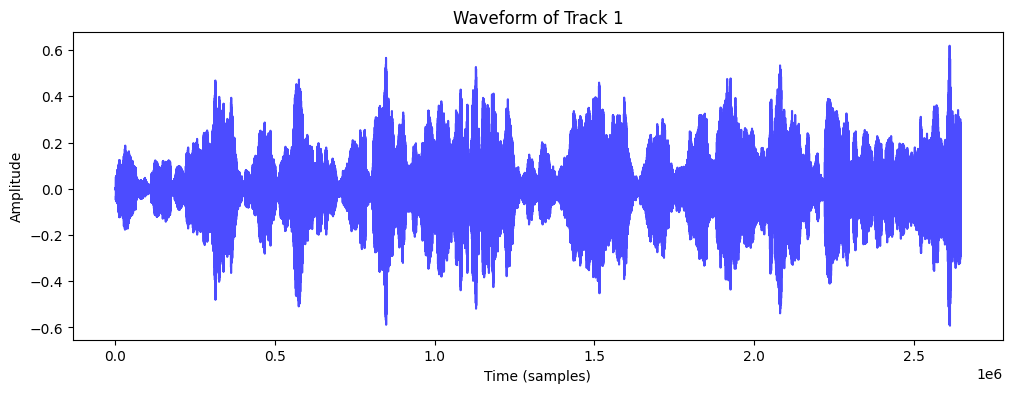

In [49]:
if audio_data:
    sample_track_id = next(iter(audio_data.keys()))
    waveform = audio_data[sample_track_id]["waveform"]
    sample_rate = audio_data[sample_track_id]["sample_rate"]

    print(f"Track {sample_track_id}: Sample Rate - {sample_rate} Hz")
    plt.figure(figsize=(12, 4))
    plt.plot(waveform, color="blue", alpha=0.7)
    plt.title(f"Waveform of Track {sample_track_id}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()
else:
    print("No audio data loaded.")


In [ ]:
audio_embeddings = {}
for track_id, audio in tqdm(audio_data.items(), desc="Generating Embeddings"):
    waveform = audio["waveform"]
    try:
        if len(waveform.shape) > 1:
            waveform = librosa.to_mono(waveform)
        waveform = waveform / np.max(np.abs(waveform))
        waveform_tensor = torch.tensor(waveform, dtype=torch.float32)
        waveform_tensor = waveform_tensor.unsqueeze(0)
        embedding = model(waveform_tensor).detach().numpy()
        audio_embeddings[track_id] = embedding
    except Exception as e:
        print(f"❌ Error processing embedding for track {track_id}: {e}")

print(f"🎯 Successfully generated embeddings for {len(audio_embeddings)} tracks.")

Generating Embeddings: 100%|██████████| 400/400 [16:20<00:00,  2.45s/it]

🎯 Successfully generated embeddings for 400 tracks.


In [ ]:
torch.save(audio_embeddings, "Audio_and_Text_Embeddings/audio_embeddings.pt")

In [55]:
np.save("audio_embeddings.npy", audio_embeddings, allow_pickle=True)

In [ ]:
json_embeddings = {k: v.tolist() for k, v in audio_embeddings.items()}
with open("audio_embeddings.json", "w") as f:
    json.dump(json_embeddings, f)

In [12]:
audio_embeddings = torch.load("audio_embeddings.pt")

C:\Users\91740\AppData\Local\Temp\ipykernel_4528\3573859161.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  audio_embeddings = torch.load("audio_embeddings.pt")


In [13]:
sample_track_id = next(iter(audio_embeddings)) 
sample_embedding = audio_embeddings[sample_track_id] 
print(f"Shape of embedding for track {sample_track_id}: {sample_embedding.shape}")

Shape of embedding for track 1: (1, 512)


In [14]:
num_tracks = len(audio_embeddings)
print(f"Total number of track IDs with embeddings: {num_tracks}")

Total number of track IDs with embeddings: 400


- Aggregate Emotions: For each unique track id, calculate its overall emotional profile based on all user annotations (e.g., the average score for each emotion).

In [15]:
emotion_cols = [
    'amazement', 'solemnity', 'tenderness', 'nostalgia',
    'calmness', 'power', 'joyful_activation', 'tension', 'sadness'
]

aggregated_emotions = emotion_data.groupby('track id')[emotion_cols].mean().reset_index()
genre_map = emotion_data.groupby('track id')['genre'].first()
aggregated_emotions = aggregated_emotions.merge(genre_map, on='track id')

print("Aggregated Emotion Profile per Track:")
print(aggregated_emotions.head())

track_emotion_profiles = aggregated_emotions.set_index('track id')[emotion_cols].to_dict(orient='index')
print("\nEmotion profile for Track 1:")
print(track_emotion_profiles.get(1))

Aggregated Emotion Profile per Track:
   track id  amazement  solemnity  tenderness  nostalgia  calmness     power  \
0         1   0.145833   0.333333    0.208333   0.291667  0.625000  0.020833   
1         2   0.106383   0.170213    0.425532   0.340426  0.744681  0.042553   
2         3   0.173913   0.347826    0.130435   0.173913  0.065217  0.282609   
3         4   0.119048   0.142857    0.523810   0.452381  0.761905  0.023810   
4         5   0.045455   0.295455    0.318182   0.522727  0.318182  0.045455   

   joyful_activation   tension   sadness      genre  
0           0.083333  0.062500  0.312500  classical  
1           0.021277  0.021277  0.106383  classical  
2           0.413043  0.239130  0.152174  classical  
3           0.000000  0.023810  0.142857  classical  
4           0.068182  0.181818  0.318182  classical  

Emotion profile for Track 1:
{'amazement': 0.14583333333333334, 'solemnity': 0.3333333333333333, 'tenderness': 0.20833333333333334, 'nostalgia': 0.291666666

- Create Track Emotion Text: Convert this aggregated emotional profile into a meaningful text description for each track. This text will represent the consensus emotion.

In [16]:
# # Emotion definitions from the dataset description
# emotion_definitions = {
#     "amazement": "Feeling of wonder and happiness",
#     "solemnity": "Feeling of transcendence, inspiration. Thrills",
#     "tenderness": "Sensuality, affect, feeling of love",
#     "nostalgia": "Dreamy, melancholic, sentimental feelings",
#     "calmness": "Relaxation, serenity, meditativeness",
#     "power": "Feeling strong, heroic, triumphant, energetic",
#     "joyful_activation": "Feels like dancing, bouncy feeling, animated, amused",
#     "tension": "Nervous, impatient, irritated",
#     "sadness": "Depressed, sorrowful"
# }

# Expanded Emotion Definitions with Synonyms and Related Feelings
emotion_definitions = {
    "amazement": ["Feeling of wonder and happiness", "Awe", "Astonishment", "Surprise", "Admiration", "Marvel", "Excitement", "Euphoria"],

    "solemnity": ["Feeling of transcendence, inspiration. Thrills", "Reverence", "Dignity", "Profoundness", "Spiritual upliftment", "Majesty", "Grandiosity", "Gracefulness"],

    "tenderness": ["Sensuality, affect, feeling of love", "Warmth", "Compassion", "Gentleness", "Affection", "Intimacy", "Care", "Kindness"],

    "nostalgia": ["Dreamy, melancholic, sentimental feelings", "Longing", "Reminiscence", "Bittersweet memories", "Yearning", "Homesickness", "Reflectiveness", "Wistfulness"],

    "calmness": ["Relaxation, serenity, meditativeness", "Peacefulness", "Tranquility", "Stillness", "Composure", "Balance", "Zen", "Contentment"],

    "power": ["Feeling strong, heroic, triumphant, energetic", "Dominance", "Confidence", "Invincibility", "Empowerment", "Authority", "Determination", "Resilience"],

    "joyful_activation": ["Feels like dancing, bouncy feeling, animated, amused", "Cheerfulness", "Playfulness", "Liveliness", "Elation", "Exuberance", "Merriment", "Upbeat energy"],

    "tension": ["Nervous, impatient, irritated", "Anxiety", "Unease", "Stress", "Agitation", "Restlessness", "Edginess", "Apprehension"],

    "sadness": ["Depressed, sorrowful", "Grief", "Melancholy", "Despair", "Heartache", "Loneliness", "Gloom", "Hopelessness"]
}


def create_emotion_text(profile, top_n=3):
    sorted_emotions = sorted(profile.items(), key=lambda item: item[1], reverse=True)
    top_emotions = [emo for emo, score in sorted_emotions[:top_n] if score > 0.05]
    if not top_emotions:
        return "Neutral or sparsely annotated"

    description = ", ".join(top_emotions).capitalize()
    return description

track_emotion_texts = {}
for track_id, profile in track_emotion_profiles.items():
    track_emotion_texts[track_id] = create_emotion_text(profile, top_n=3)

print(f"\nGenerated text for Track 1: '{track_emotion_texts.get(1)}'")
print(f"Generated text for Track 400: '{track_emotion_texts.get(400)}'")


Generated text for Track 1: 'Calmness, solemnity, sadness'
Generated text for Track 400: 'Tension, sadness, nostalgia'


- Generate Text Embeddings: Use a sentence embedding model (like Sentence-BERT) to create vector embeddings for:

> The text description of each track's aggregated emotion.

> The user's input query (e.g., "Dreamy, melancholic, sentimental feelings").

In [19]:
model_name = 'multi-qa-mpnet-base-dot-v1'
text_embedding_model = SentenceTransformer(model_name)

track_ids_list = list(track_emotion_texts.keys())
track_texts_list = list(track_emotion_texts.values())

print(f"\nGenerating text embeddings for {len(track_texts_list)} tracks using {model_name}...")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

track_text_embeddings_tensor = text_embedding_model.encode(
    track_texts_list,
    convert_to_tensor=True,
    show_progress_bar=True,
    device=device
)

print(f"Generated embeddings tensor shape: {track_text_embeddings_tensor.shape}")
track_text_embeddings = {tid: emb for tid, emb in zip(track_ids_list, track_text_embeddings_tensor)}


Generating text embeddings for 400 tracks using multi-qa-mpnet-base-dot-v1...


Batches: 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]

Generated embeddings tensor shape: torch.Size([400, 768])


In [20]:
pt_tensor_filename = "track_text_embeddings_tensor.pt"
pt_dict_filename = "track_text_embeddings_dict.pt"
json_filename = "track_text_embeddings.json"

In [21]:
try:
    torch.save(track_text_embeddings_tensor, pt_tensor_filename)
    print(f"✅ Successfully saved embeddings tensor to: {pt_tensor_filename}")
except Exception as e:
    print(f"❌ Error saving tensor to {pt_tensor_filename}: {e}")

✅ Successfully saved embeddings tensor to: track_text_embeddings_tensor.pt


In [22]:
try:
    torch.save(track_text_embeddings, pt_dict_filename)
    print(f"✅ Successfully saved embeddings dictionary to: {pt_dict_filename}")
except Exception as e:
    print(f"❌ Error saving dictionary to {pt_dict_filename}: {e}")

✅ Successfully saved embeddings dictionary to: track_text_embeddings_dict.pt


In [25]:
print(f"\n⚙️ Preparing embeddings for JSON serialization...")
json_embeddings = {}
conversion_errors = 0

for track_id, embedding_tensor in track_text_embeddings.items():
    try:
        if embedding_tensor.device.type == 'cuda':
            embedding_list = embedding_tensor.cpu().numpy().tolist()
        else:
            embedding_list = embedding_tensor.numpy().tolist()
        json_embeddings[track_id] = embedding_list

    except Exception as e:
        print(f"⚠️ Error converting embedding for track {track_id} to list: {e}")
        conversion_errors += 1

if conversion_errors == 0:
    print(f"✅ Conversion successful for all {len(json_embeddings)} embeddings.")
    try:
        with open(json_filename, 'w') as f:
            json.dump(json_embeddings, f, indent=4)
        print(f"✅ Successfully saved embeddings dictionary to JSON: {json_filename}")
    except Exception as e:
        print(f"❌ Error saving dictionary to {json_filename}: {e}")
else:
    print(f"❌ Could not save to JSON due to {conversion_errors} conversion errors.")


⚙️ Preparing embeddings for JSON serialization...
✅ Conversion successful for all 400 embeddings.
✅ Successfully saved embeddings dictionary to JSON: track_text_embeddings.json


In [41]:
user_query = "show me loops that feel like heartbreak in spring"
query_embedding = text_embedding_model.encode(user_query, convert_to_tensor=True, device=device)

print(f"\nQuery: '{user_query}'")
print(f"Query embedding shape: {query_embedding.shape}")


Query: 'show me loops that feel like heartbreak in spring'
Query embedding shape: torch.Size([768])


- Semantic Search: Calculate the similarity (e.g., cosine similarity) between the user's query embedding and all the track emotion text embeddings.

In [42]:
cosine_scores = util.cos_sim(query_embedding, track_text_embeddings_tensor)[0]
cosine_scores = cosine_scores.cpu().tolist()

results = []
for i, score in enumerate(cosine_scores):
    track_id = track_ids_list[i]
    results.append({
        "track_id": track_id,
        "similarity_score": score,
        "emotion_text": track_emotion_texts[track_id],
        "top_emotions": track_emotion_profiles.get(track_id, {})
    })

results.sort(key=lambda x: x["similarity_score"], reverse=True)

print(f"\nSearch Results for query: '{user_query}'")


Search Results for query: 'show me loops that feel like heartbreak in spring'


In [44]:
similarity_threshold = 0.5
top_n = 5

filtered_results = [res for res in results if res["similarity_score"] >= similarity_threshold]
top_results = filtered_results[:top_n]

print(f"Found {len(filtered_results)} tracks with similarity >= {similarity_threshold}")
print(f"Showing Top {len(top_results)}:")

for rank, res in enumerate(top_results):
    print(f"--- Rank {rank+1} ---")
    print(f"  Track ID: {res['track_id']}")
    print(f"  Similarity: {res['similarity_score']:.4f}")
    print(f"  Matched Emotion Text: '{res['emotion_text']}'")

    top_track_emotions = sorted(res['top_emotions'].items(), key=lambda item: item[1], reverse=True)
    print(f"  Detailed Scores: {[(emo, f'{score:.2f}') for emo, score in top_track_emotions if score > 0.05]}")

    audio_emb = audio_embeddings.get(res['track_id'])
    if audio_emb is not None:
       print(f"  (Audio embedding shape: {audio_emb.shape})")
    else:
       print("  (Audio embedding not found)")

Found 6 tracks with similarity >= 0.5
Showing Top 5:
--- Rank 1 ---
  Track ID: 164
  Similarity: 0.5213
  Matched Emotion Text: 'Tenderness, nostalgia, sadness'
  Detailed Scores: [('tenderness', '0.43'), ('nostalgia', '0.43'), ('sadness', '0.36'), ('calmness', '0.29'), ('amazement', '0.14'), ('solemnity', '0.14'), ('joyful_activation', '0.14'), ('power', '0.07'), ('tension', '0.07')]
  (Audio embedding shape: (1, 512))
--- Rank 2 ---
  Track ID: 332
  Similarity: 0.5213
  Matched Emotion Text: 'Tenderness, nostalgia, sadness'
  Detailed Scores: [('tenderness', '0.64'), ('nostalgia', '0.45'), ('sadness', '0.36'), ('joyful_activation', '0.27'), ('calmness', '0.18'), ('amazement', '0.09'), ('solemnity', '0.09'), ('tension', '0.09')]
  (Audio embedding shape: (1, 512))
--- Rank 3 ---
  Track ID: 193
  Similarity: 0.5187
  Matched Emotion Text: 'Sadness, nostalgia, tenderness'
  Detailed Scores: [('sadness', '0.62'), ('nostalgia', '0.54'), ('tenderness', '0.46'), ('calmness', '0.46'), ('s

- Retrieve Audio: Return the track ids (and thus the corresponding audio/audio embeddings) of the tracks with the highest similarity scores above your threshold.

In [ ]:
similarity_threshold = 0.5 
top_n = 5

filtered_results = [res for res in results if res["similarity_score"] >= similarity_threshold]
top_results = filtered_results[:top_n]

print(f"Found {len(filtered_results)} tracks with similarity >= {similarity_threshold}")
print(f"Showing Top {min(len(top_results), top_n)}:")

audio_output_area = widgets.Output()

def play_track_callback(track_id_to_play, button_instance):
    """Called when a 'Play Track X' button is clicked."""
    with audio_output_area:
        clear_output(wait=True) 
        audio_info = audio_data.get(track_id_to_play)
        if audio_info:
            waveform = audio_info["waveform"]
            sample_rate = audio_info["sample_rate"]
            print(f"▶️ Loading Track {track_id_to_play}...")
            if isinstance(waveform, np.ndarray):
                display(Audio(waveform, rate=sample_rate, autoplay=True))
            else:
                print("❌ Invalid waveform format for Track {track_id_to_play}")
        else:
            print(f"❌ Audio data not found for Track {track_id_to_play}")

widgets_to_display = [] 

for rank, res in enumerate(top_results):
    track_id = res['track_id']

    info_html = f"""
    <hr>
    <b>Rank {rank+1}</b><br>
    <b>Track ID:</b> {track_id}<br>
    <b>Similarity:</b> {res['similarity_score']:.4f}<br>
    <b>Matched Emotion Text:</b> '{res['emotion_text']}'<br>
    """

    top_track_emotions = sorted(res['top_emotions'].items(), key=lambda item: item[1], reverse=True)
    detailed_scores_str = ', '.join([f"{emo}: {score:.2f}" for emo, score in top_track_emotions if score > 0.05])
    info_html += f"<b>Detailed Scores:</b> {detailed_scores_str}<br>"

    audio_emb = audio_embeddings.get(track_id)
    if audio_emb is not None and hasattr(audio_emb, 'shape'):
        info_html += f"<b>Audio Embedding Shape:</b> {audio_emb.shape}<br>"
    else:
        info_html += "<b>Audio Embedding:</b> Not Found or invalid shape<br>"

    audio_info = audio_data.get(track_id)
    if audio_info:
        sample_rate = audio_info["sample_rate"]
        duration = librosa.get_duration(y=audio_info["waveform"], sr=sample_rate)
        info_html += f"<b>Sample Rate:</b> {sample_rate} Hz<br>"
        info_html += f"<b>Duration:</b> {duration:.2f} seconds<br>"
    else:
         info_html += "<b>Raw Audio Data:</b> Not Found<br>"

    info_widget = widgets.HTML(value=info_html)
    widgets_to_display.append(info_widget)

    if audio_info:
        play_button = widgets.Button(
            description=f"Play Track {track_id}",
            button_style='success', 
            tooltip=f'Click to play audio for track {track_id}',
            icon='play'
        )

        callback_with_id = functools.partial(play_track_callback, track_id)
        play_button.on_click(callback_with_id)
        widgets_to_display.append(play_button)

display(widgets.VBox(widgets_to_display))

print("\n" + "="*30)
print("Audio Player Output Area (active when button clicked):")
print("="*30)
display(audio_output_area)

if not top_results:
    print("No tracks found matching the criteria.")

Found 6 tracks with similarity >= 0.5
Showing Top 5:



Audio Player Output Area (active when button clicked):


Output()